# ***1. Import the required libraries***
1. conda install tensorflow-datasets
2. conda install scikit-learn
3. conda install seaborn


In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.datasets import mnist


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# ***2. Data Acquisition***
https://www.tensorflow.org/datasets/catalog/cifar10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## ***2.1 Display the Original Image***

In [ ]:
def show_images(images, labels=None, num=5, cmap=None, figsize=(15, 3)):
	plt.figure(figsize=figsize)
	for i in range(num):
					plt.subplot(1, num, i+1)
					if images.ndim == 4:  # e.g. (N, H, W, 3) or (N, H, W, 1)
									img = images[i]
									# if single channel, squeeze to 2D for imshow
									if img.shape[-1] == 1:
													img = img.squeeze(-1)
									plt.imshow(img, cmap=cmap)
					elif images.ndim == 3:  # e.g. (N, H, W)
									plt.imshow(images[i], cmap=cmap)
					else:
									raise ValueError("Unsupported image array shape")

					if labels is not None:
									plt.title(f"Label: {labels[i]}")
					plt.axis('off')
	plt.show()

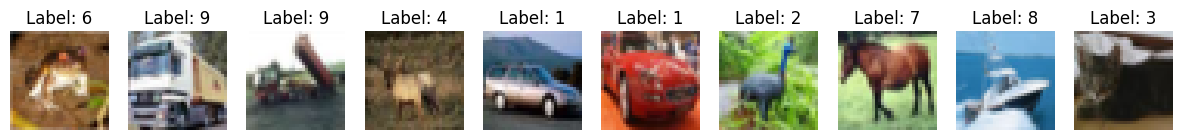

In [ ]:
show_images(x_train, labels=y_train.flatten(), num=10, cmap='gray')

# ***3. Data Preparation /Normalizatoin based on Images***

In [ ]:
# Convert to float in [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Now convert to grayscale
x_train_gray = np.array([rgb2gray(img) for img in x_train])  # shape: (50000, 32, 32)
x_test_gray = np.array([rgb2gray(img) for img in x_test])    # shape: (10000, 32, 32)

# Add channel dimension for Conv2D
x_train_gray = x_train_gray[..., np.newaxis]  # shape: (50000, 32, 32, 1)
x_test_gray = x_test_gray[..., np.newaxis]

In [ ]:
print(np.min(x_train_gray), np.max(x_train_gray))


0.0 0.99999994


# ***4. Deep Convolutional AutoEncoder***

In [ ]:
input_img = layers.Input(shape=(32, 32, 1))

# Encoder
x = layers.Conv2D(16, (3, 3),  padding='same')(input_img)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 16x16
x = layers.Conv2D(32, (3, 3), padding='same')(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 8x8
x = layers.Conv2D(64, (3, 3),  padding='same')(x)
x = layers.ReLU()(x)
#encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # 4x4 latent space
x=layers.MaxPooling2D((2, 2), padding='same')(x)  # 4x4 latent space
encoded = layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same')(x)  #
# Decoder
x = layers.Conv2D(64, (3, 3),  padding='same')(encoded)
x = layers.ReLU()(x)
x = layers.UpSampling2D((2, 2))(x)  # 8x8
x = layers.Conv2D(32, (3, 3),  padding='same')(x)
x = layers.ReLU()(x)
x = layers.UpSampling2D((2, 2))(x)  # 16x16
x = layers.Conv2D(16, (3, 3), padding='same')(x)
x = layers.ReLU()(x)
x = layers.UpSampling2D((2, 2))(x)  # 32x32

# Output layer with 1 channel for grayscale
decoded = layers.Conv2D(1, (3, 3), activation='linear', padding='same')(x)

# Build model
conv_autoencoder  = models.Model(input_img, decoded)
conv_autoencoder .compile(optimizer='adam', loss='mse')


# ***5. Single Fully connected layer Autoencoder***

In [ ]:
input_img = layers.Input(shape=(32, 32, 1))
flat = layers.Flatten()(input_img)  # shape: (None, 1024)
latent_dim = 128
# Encoder: single hidden layer with sigmoid activation
encoded = layers.Dense(latent_dim, activation='sigmoid')(flat)
# Decoder: linear activation (no activation)
decoded = layers.Dense(32*32, activation='linear')(encoded)

# Reshape back to image shape
decoded_img = layers.Reshape((32, 32, 1))(decoded)

fc_autoencoder = models.Model(input_img, decoded_img)
fc_autoencoder.compile(optimizer='adam', loss='mse')


# ***6. Three Hidden Layer Autoencoder***

In [ ]:


total_hidden_nodes = 128
nodes_per_layer = total_hidden_nodes // 3  # integer division

input_img = layers.Input(shape=(32, 32, 1))
flat = layers.Flatten()(input_img)

# Encoder: 3 hidden layers with sigmoid activation
x = layers.Dense(nodes_per_layer, activation='sigmoid')(flat)
x = layers.Dense(nodes_per_layer, activation='sigmoid')(x)
encoded = layers.Dense(nodes_per_layer, activation='sigmoid')(x)

# Decoder: mirror the encoder
x = layers.Dense(nodes_per_layer, activation='sigmoid')(encoded)
x = layers.Dense(nodes_per_layer, activation='sigmoid')(x)
decoded = layers.Dense(32*32, activation='linear')(x)

decoded_img = layers.Reshape((32, 32, 1))(decoded)

fc3_autoencoder = models.Model(input_img, decoded_img)
fc3_autoencoder.compile(optimizer='adam', loss='mse')


# ***7.Model Report***
*   Deep Convolution AutoEncoder
*   Single Hidden layer AutoEncoder
*   Three Hidden layer AutoEncoder

In [ ]:
conv_autoencoder.summary()
fc_autoencoder.summary()
fc3_autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 582,533 (2.22 MB)

 Trainable params: 194,177 (758.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 388,356 (1.48 MB)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789,890 (3.01 MB)

 Trainable params: 263,296 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 526,594 (2.01 MB)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 42)             │        43,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 42)             │         1,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1024)           │        44,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 32, 32, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,306 (368.38 KB)

 Trainable params: 94,306 (368.38 KB)

 Non-trainable params: 0 (0.00 B)

# ***8. Model Training***

In [ ]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train convolutional autoencoder
conv_autoencoder.fit(x_train_gray, x_train_gray,epochs=50,batch_size=128,validation_data=(x_test_gray, x_test_gray))

# Train fully connected autoencoder
fc_autoencoder.fit(x_train_gray, x_train_gray,epochs=50,batch_size=128,validation_data=(x_test_gray, x_test_gray))

# Train fully 3 hidden layer connected autoencoder
fc3_autoencoder.fit(x_train_gray, x_train_gray,epochs=50,batch_size=128,validation_data=(x_test_gray, x_test_gray))

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 12/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step

# ***9. Reconstrunction Error Evaluation***

In [ ]:
import numpy as np

# Predict reconstructions
conv_decoded = conv_autoencoder.predict(x_test_gray)
fc_decoded = fc_autoencoder.predict(x_test_gray)
fc3_decoded = fc3_autoencoder.predict(x_test_gray)

# Compute mean squared error per sample and average
def mse_per_sample(original, reconstructed):
    return np.mean(np.square(original - reconstructed), axis=(1,2,3))

conv_errors = mse_per_sample(x_test_gray, conv_decoded)
fc_errors = mse_per_sample(x_test_gray, fc_decoded)
fc3_errors = mse_per_sample(x_test_gray, fc3_decoded)

print("Conv Autoencoder Mean Reconstruction Error:Mean {:.6f} Standard deviation± {:.6f}", np.mean(conv_errors), np.std(conv_errors))
print("FC Autoencoder Mean Reconstruction Error:Mean {:.6f} Standard deviation± {:.6f}", np.mean(fc_errors), np.std(fc_errors))
print("FC3 Autoencoder Mean Reconstruction Error:Mean {:.6f} Standard deviation± {:.6f}", np.mean(fc3_errors), np.std(fc3_errors))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Conv Autoencoder Mean Reconstruction Error:Mean {:.6f} Standard deviation± {:.6f} 0.0026904666 0.0014324447
FC Autoencoder Mean Reconstruction Error:Mean {:.6f} Standard deviation± {:.6f} 0.0038774712 0.0021523393
FC3 Autoencoder Mean Reconstruction Error:Mean {:.6f} Standard deviation± {:.6f} 0.026527882 0.015771205


In [ ]:
import matplotlib.pyplot as plt

def show_reconstruction(original, reconstructed, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_reconstruction(x_test_gray, conv_decoded, n=10)

NameError: name 'x_test_gray' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pick N random test images
n = 10
indices = np.random.choice(len(x_test_gray), n)
test_imgs = x_test_gray[indices]

# Get reconstructions
recon_cae = conv_autoencoder.predict(test_imgs)
recon_fcae = fc_autoencoder.predict(test_imgs)

# Plotting
plt.figure(figsize=(12, 5))

for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_imgs[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Conv Autoencoder
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(recon_cae[i].squeeze(), cmap='gray')
    plt.title("Conv AE")
    plt.axis("off")

    # FC Autoencoder
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(recon_fcae[i].squeeze(), cmap='gray')
    plt.title("FC AE")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_reconstructions(orig, reconstructions, model_names, n=5):
    plt.figure(figsize=(15, 8))
    total_rows = len(reconstructions) + 1  # +1 for original
    total_cols = n

    for i in range(n):
        # Original image row (row 0)
        ax = plt.subplot(total_rows, total_cols, i + 1)
        plt.imshow(orig[i].squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed images rows (rows 1,2,...)
        for j, recon in enumerate(reconstructions):
            ax = plt.subplot(total_rows, total_cols, (j + 1) * total_cols + i + 1)
            plt.imshow(recon[i].squeeze(), cmap='gray')
            plt.title(model_names[j])
            plt.axis('off')
    plt.tight_layout()
    plt.show()
# Call with your models' reconstructions and names
plot_reconstructions(
    x_test_gray,
    [conv_decoded, fc_decoded, fc3_decoded],
    ["Conv AE", "FC 1-hidden AE", "FC 3-hidden AE"],
    n=5
)